In [5]:
import tensorflow as tf
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
import keras
from keras import layers

In [6]:

screen_x = 3840
screen_y = 2200
directory = "FEB_16"
batch_size = 128
seed=42

image_size = (800, 1000)
images_path = f"C:\\Users\\Cyril\\Desktop\\data-science-lab\\eyeball tracker\\{directory}"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    images_path,
    label_mode=None,
    image_size=image_size,
    batch_size=batch_size,
    seed=seed,
    validation_split=0.2,
    subset="training"
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    images_path,
    label_mode=None,
    image_size=image_size,
    batch_size=batch_size,
    seed=seed,
    validation_split=0.2,
    subset="validation"
)

def add_dummy_labels(images):
    """Dummy labels generation as classification is a common task but not regression
    """
    return images, tf.zeros((tf.shape(images)[0], 1))

train_data = train_ds.map(add_dummy_labels).prefetch(tf.data.AUTOTUNE)
val_data = val_ds.map(add_dummy_labels).prefetch(tf.data.AUTOTUNE)


image_files = [f for f in os.listdir(images_path) if os.path.isfile(os.path.join(images_path, f)) and not f.endswith('.csv')]
image_names = [os.path.splitext(f)[0] for f in image_files]
image_paths = [os.path.join(images_path, f) for f in image_files]
train_df = pd.DataFrame({'id': image_names, 'file_name': image_paths})
target_csv = pd.read_csv(f"C:\\Users\\Cyril\\Desktop\\data-science-lab\\eyeball tracker\\{directory}\\target.csv", index_col="id")
train_df = pd.concat([train_df, target_csv], axis=1)
train_df.tail()

train_df["x_coordinate"] = train_df["x_coordinate"] / screen_x
train_df["y_coordinate"] = train_df["y_coordinate"] / screen_y

train_files, val_files, train_x, val_x, train_y, val_y = train_test_split(
    train_df["file_name"].values, train_df["x_coordinate"].values, train_df["y_coordinate"].values, test_size=0.2, random_state=42
)

train_labels = list(zip(train_x, train_y))
val_labels = list(zip(val_x, val_y))

def load_image(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (128, 128)) / 255.0
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((train_files, train_labels)).map(load_image).batch(16).shuffle(1000)
val_ds = tf.data.Dataset.from_tensor_slices((val_files, val_labels)).map(load_image).batch(16)

Found 2500 files belonging to 1 classes.
Using 2000 files for training.
Found 2500 files belonging to 1 classes.
Using 500 files for validation.


In [7]:
epochs = 50
activation = 'relu' #trial.suggest_categorical('activation', ['relu', 'leaky_relu', 'elu'])
nb_layers = 3 #trial.suggest_int('number of layers', 1, 7)
nb_neurons = 90 #trial.suggest_int('number of neurons per layer', 16, 32)
dropout_rate = 0.6

data_augmentation = keras.Sequential([
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomBrightness(factor=0.2),
    layers.RandomContrast(factor=0.2),
])


inputs = keras.Input(shape=(128, 128, 3))
x = data_augmentation(inputs)
x = inputs

# First block
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2, 2)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(dropout_rate)(x)

# Second block
x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2, 2)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(dropout_rate)(x)

# Third block
x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2, 2)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(dropout_rate)(x)

# Fully connected layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(dropout_rate)(x)
outputs = layers.Dense(2)(x)

model = keras.Model(inputs, outputs)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])


lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 0.002 * 0.99 ** (epoch*0.01))
# plateau_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.8, patience=10, min_lr=1e-6, verbose=1)
# early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
# checkpoint = keras.callbacks.ModelCheckpoint(
#     "models/epoch_{epoch:02d}.h5",
#     save_best_only=True,
#     save_weights_only=False,
#     verbose=1
# )

# callbacks = [lr_schedule, plateau_lr, early_stopping, checkpoint]
# callbacks = [lr_schedule, checkpoint]
callbacks = [lr_schedule]

In [8]:
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks, verbose=1, shuffle=True)

Epoch 1/50
125/125 [==============================] - 15s 109ms/step - loss: 0.1315 - mae: 0.2956 - val_loss: 0.5700 - val_mae: 0.6507 - lr: 0.0020
Epoch 2/50
125/125 [==============================] - 16s 119ms/step - loss: 0.0980 - mae: 0.2630 - val_loss: 0.1093 - val_mae: 0.2822 - lr: 0.0020
Epoch 3/50
125/125 [==============================] - 16s 118ms/step - loss: 0.0920 - mae: 0.2563 - val_loss: 0.0993 - val_mae: 0.2702 - lr: 0.0020
Epoch 4/50
125/125 [==============================] - 16s 120ms/step - loss: 0.0895 - mae: 0.2545 - val_loss: 0.2474 - val_mae: 0.4185 - lr: 0.0020
Epoch 5/50
125/125 [==============================] - 15s 114ms/step - loss: 0.0883 - mae: 0.2522 - val_loss: 0.0843 - val_mae: 0.2468 - lr: 0.0020
Epoch 6/50
125/125 [==============================] - 15s 112ms/step - loss: 0.0852 - mae: 0.2488 - val_loss: 0.1702 - val_mae: 0.3432 - lr: 0.0020
Epoch 7/50
125/125 [==============================] - 15s 114ms/step - loss: 0.0835 - mae: 0.2455 - val_loss: 0.

In [13]:
model_name = "shuffled.h5"
model.save(model_name)

In [14]:
import tensorflow as tf
       
model = tf.keras.models.load_model(model_name)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 64, 64, 64)        0   

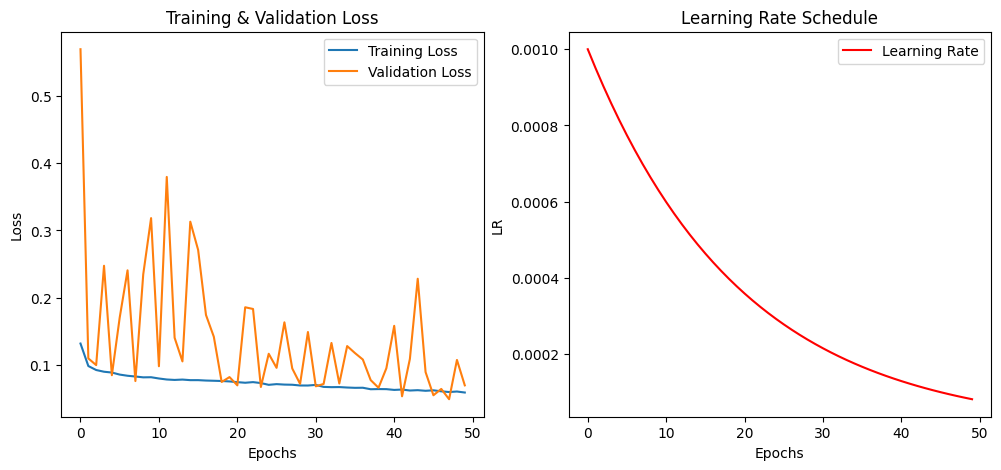

In [15]:
import matplotlib.pyplot as plt

# Extract loss, val_loss, and learning rate
loss = history.history['loss']
val_loss = history.history['val_loss']
lrs = [0.001 * 0.95 ** epoch for epoch in range(len(loss))]

# Plot loss and val_loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")

# Plot learning rate
plt.subplot(1, 2, 2)
plt.plot(lrs, label="Learning Rate", color="red")
plt.xlabel("Epochs")
plt.ylabel("LR")
plt.legend()
plt.title("Learning Rate Schedule")

plt.show()


In [12]:
import shap
import numpy as np
import tensorflow as tf
import cv2

# Load a background dataset (needed for GradientExplainer)
background = np.random.normal(size=(10, 128, 128, 3))

# Initialize SHAP explainer
explainer = shap.GradientExplainer(model, background)

# Capture an image
image_id = "42"
image_path = f"{image_id}.jpg"
image = preprocess_image(image_path).numpy()  # Ensure it matches model input
image = np.expand_dims(image, axis=0)  # Add batch dimension if needed

# Get SHAP values
shap_values = explainer.shap_values(image, nsamples=1)  
shap_values = shap_values[0]  # Select the first output (if multiple outputs)
shap_values = np.mean(shap_values, axis=-1)  # Convert to grayscale

# Normalize SHAP values for better visualization
shap_values /= np.abs(shap_values).max()

# Resize the input image for visualization
resized_image = cv2.imread(image_path)
resized_image = cv2.resize(resized_image, (128, 128)) / 255.0  # Normalize image

# Visualize
shap.image_plot([shap_values], np.array([resized_image]))



c:\Users\Cyril\miniconda3\envs\dev\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'preprocess_image' is not defined